## What is MSE about?
MSE or Maximum Square Estimation is about maximizing the geometric mean of spacings in the data. Such spacings are the differences between the values of the cumulative distribution function at neighbouring data points. Is also known as the Maximum Product of space estimations or MSP. The idea is of choosing the parameter values that make the observed data as uniform as possible, according to a specific quantitative measure of uniformity.

MSE tends to be better than ML at estimating "J" distributions. So lets try it out with a type I Pareto! 

## Imports and constants

In [1]:
import numpy as np
from scipy.stats.mstats import gmean
from scipy.stats import pareto
import matplotlib.pyplot as plt
print plt.style.available
plt.style.use('ggplot')

[u'seaborn-darkgrid', u'seaborn-notebook', u'classic', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', u'seaborn-dark-palette']


In [2]:
#this is the real shape parameter that we will try to approximate with the estimators
realAlpha=3.
#the left limit of this Pareto distribution
realXm=1.
#pareto distribution CDF (all xi in x are >=1)
parICDF= lambda x,alpha: 1.-(realXm/x)**alpha
#number of samples to estimate from
nSamples=400
#multiplier for alphas in the search
multAlphas=100.
#select some range of alphas from which to do the MSE
low=1.0
high=5.0
alphasForSearch=np.linspace(low,high,num=(high-low)*multAlphas)
#which distribution
distribution=pareto

def sampleSpacings(x):
    #calculates the sample spacings of X
    D=[xi-x[i] for i,xi in enumerate(x[1:])]
    return np.array(D)
        
        

We start with the assumption of a variable X with a CDF $F(x;\theta_0)$, where $\theta_0 \in \Theta$ is an unknown parameter to be estimated, and from which we can take iid random samples. 

The spacings over which we will estimate the geometric mean ($D_i$) are the the differences between $F(x(i);\theta)$ and $F(x(i-1);\theta)$, for i [1,n+1].

With those assumptions, we do the following: 

In [12]:
#take "repetitions" samples from each sample size
allSamplesizes=[10,50,100,300,500,10000]
results={'ML':{sz:[] for sz in allSamplesizes},
         'MSE':{sz:[] for sz in allSamplesizes}}
#score={'ML':{sz:[] for sz in allSamplesizes},
#         'MSE':{sz:[] for sz in allSamplesizes}}
repetitions=400 #take "repetitions" times for that sample size
for samplesize in allSamplesizes: #using the keys for the different sample sizes
    for n in range(repetitions):
        #Get an iid random sample ${x1, …, xn}$ from a variable.
        sample=distribution.rvs(realAlpha,size=samplesize)
        #Sort the elements of the samples. This becomes the ordered sample ${x(1), …, x(n)}$. 
        orderedSample=np.sort(sample)
        #logarithm of the geometric mean of the sample spacings from the CDF. 
        #the CDF comes from an expression that requests samples (X) 
        #and an alpha paramter
        scoresMSE=np.array([np.log(gmean(sampleSpacings(parICDF(orderedSample,alphax)))) for alphax in alphasForSearch])
        #print 'MSE scores: {}'.format(scoresMSE)
        bestMSE=scoresMSE.argmax()
        results['MSE'][samplesize].append(alphasForSearch[bestMSE])
        #score['MSE'][samplesize].append(scoresMSE[bestMSE])
        #print 'best alpha MSE:{} -> {}'.format(alphasForSearch[bestMSE],scoresMSE[bestMSE])
        #now lets look at log scores for ML
        scoresML=np.array([np.sum(np.log(distribution.pdf(sample,alphax)))/nSamples for alphax in alphasForSearch])
        bestML=scoresML.argmax()
        results['ML'][samplesize].append(alphasForSearch[bestML])
        #score['ML'][samplesize].append(scoresML[bestML])
        #print 'ML scores: {}'.format(scoresML)
        #print 'best alpha ML: {} -> {}'.format(alphasForSearch[bestML],scoresML[bestML])

for this nice plot I took some inspiration from this stack overflow answer:
http://stackoverflow.com/questions/29779079/adding-a-scatter-of-points-to-a-boxplot-using-matplotlib

Basically, we put all the points at around their location in the boxplot, but we "move them around" a bit so that is easier for the eye to see how dense the areas in the boxplot look like. Is more of a way to make the plot easier to look at, yet the boxplot has pretty much all the information you will need in this case. 

In [13]:
xx=[]
yy=[]

for indx,samplesize in enumerate(allSamplesizes):
    yy.append(results['MSE'][samplesize])
    xx.append(np.random.normal(len(yy), 0.04, size=len(results['MSE'][samplesize])))
    yy.append(results['ML'][samplesize])
    xx.append(np.random.normal(len(yy), 0.04, size=len(results['MSE'][samplesize])))
    
print np.shape(yy)
print np.shape(xx)

(12L, 400L)
(12L, 400L)


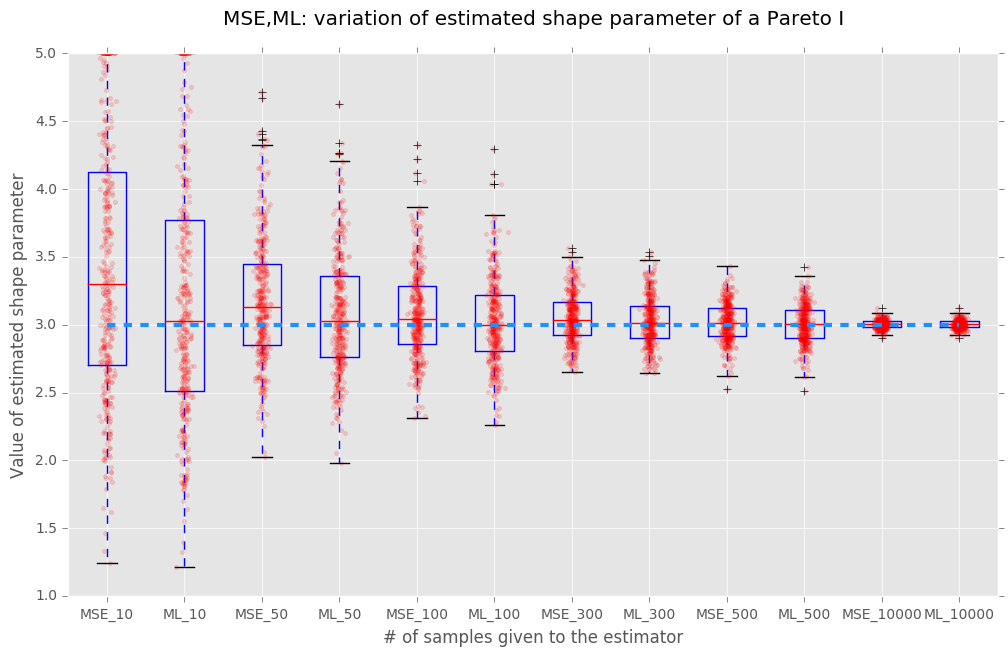

In [14]:
import pylab as P

P.figure(figsize=(12,7)) #size in inches    

bp = P.boxplot(yy)
P.plot(xx,yy, 'r.', alpha=0.15)

P.xticks([x+1 for x in range(len(yy))], [x.format(sz) for sz in allSamplesizes for x in ('MSE_{}','ML_{}')])
P.xlabel('# of samples given to the estimator')
P.ylabel('Value of estimated shape parameter')
P.title('MSE,ML: variation of estimated shape parameter of a Pareto I\n')

#horiz line with true shape value
P.plot([x+1 for x in range(len(yy))],realAlpha*np.ones(len(yy)),
       color='dodgerblue', ls='dashed',linewidth='3')

P.show()


## Moar Plots

Allright. This is how the CDF of Pareto I looks like. And there, some colors with funny names.

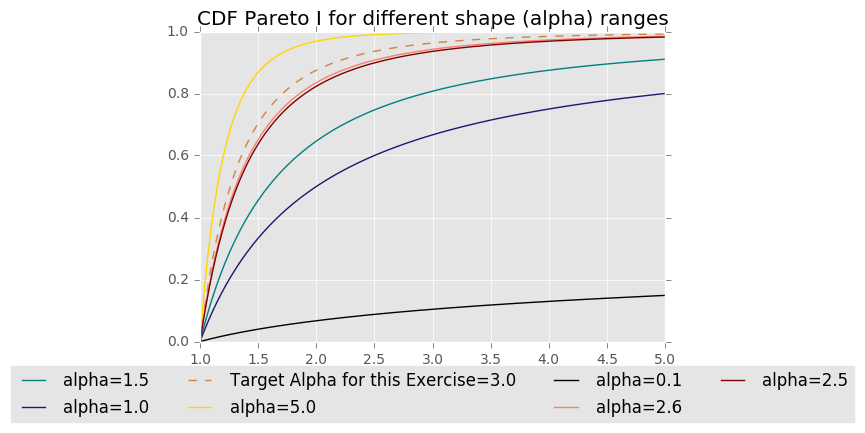

In [6]:
#lets plot some CDFs of the pareto I CDF, for different alphas
alphasubset={0.1:'black',
             1.:'midnightblue',
             1.5:'teal',
             2.5:'maroon',
             2.6:'salmon',
             3.:'peru',
             5.:'gold'}
x=np.linspace(realXm,5,num=300)
fig = plt.figure()
ax = plt.subplot(111)    
plt.title('CDF Pareto I for different shape (alpha) ranges')
for alphax in alphasubset:
    if alphax==realAlpha:
        ax.plot(x, parICDF(x,alphax), color=alphasubset[alphax], ls='dashed', 
                 label='Target Alpha for this Exercise={}'.format(alphax))
    else:
        ax.plot(x, parICDF(x,alphax), color=alphasubset[alphax], label='alpha={}'.format(alphax))
boxp = ax.get_position()
ax.set_position([boxp.x0, boxp.y0, boxp.width, boxp.height])
# Put a legend to the right of the current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),ncol=4)
plt.grid(True)
plt.show()

